# Lab 2 Presentation 1

In [1]:
import ugradio
import numpy as np

import ugradio.pico as pico
import ugradio.dft as dft
import ugradio.doppler as doppler
import ugradio.nch as nch
import ugradio.timing as timing

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, Layout

import astropy
import unittest

## Gather Data

In [59]:
cold_data_1 = np.load('../Data/big_horn_data_1000.npy.zip')
cal_data_1 = np.load('../Data/big_horn_data_1000.npz.zip')
cold_data_2 = np.load('../Data/50mV cold data.npz')
cal_data_2 = np.load('../Data/50mV data with rain.npz')


#cold_data = cold_data_1['big_horn_data_1000'][0] - (cold_data_1["big_horn_data_1000"][1]*5/4*1j)
#cal_data = cal_data_1['big_horn_data_1000'][0] - (cal_data_1["big_horn_data_1000"][1]*5/4*1j)
cold_data = cold_data_2['arr_0'][0] - (cold_data_2["arr_0"][1]*5/4*1j)
cal_data = cal_data_2['arr_0'][0] - (cal_data_2["arr_0"][1]*5/4*1j)
#cold_data = galactic_data[0] - (galactic_data[1]*5/4*1j)

# resize blocks
cold_data.shape = (-1, 2000)
cal_data.shape = (-1, 2000)

In [60]:
cal_data.shape

(800, 2000)

In [61]:
cold_data.shape

(8000, 2000)

## Plot Raw Horn Data

<IPython.core.display.Javascript object>


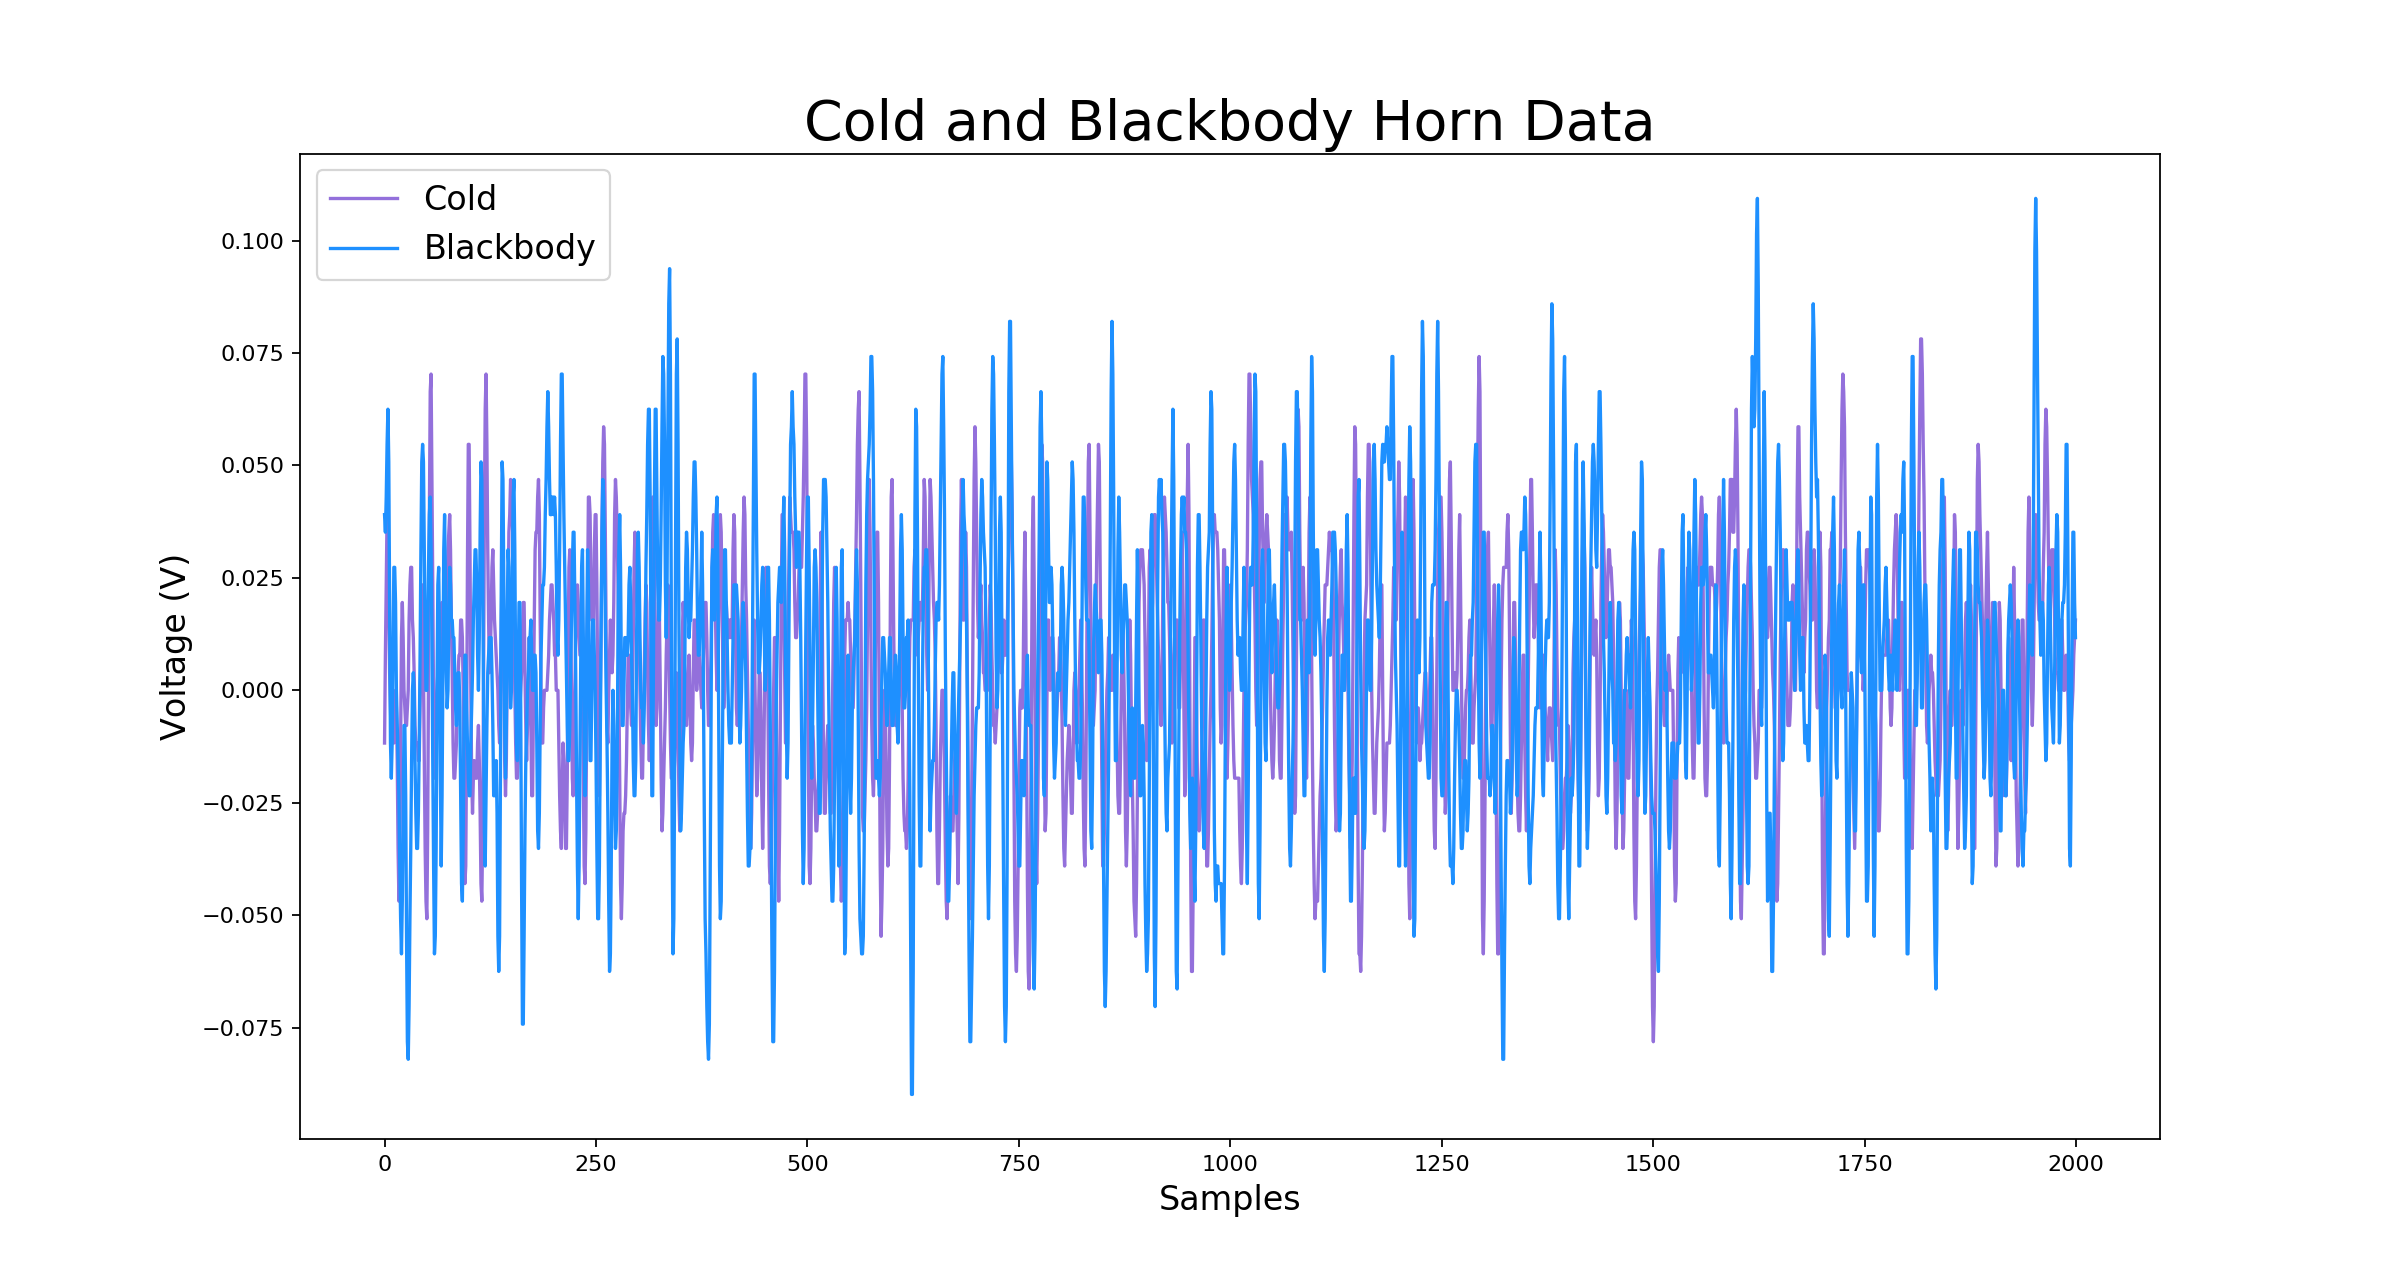

In [62]:
plt.figure(figsize=(15, 8))
plt.plot(cold_data[0]/2**16, "mediumpurple", label="Cold")
plt.plot(cal_data[0]/2**16, "dodgerblue", label="Blackbody")
plt.xlabel("Samples", fontsize=15)
plt.ylabel("Voltage (V)", fontsize=15)
plt.title("Cold and Blackbody Horn Data", fontsize=25)
plt.legend(fontsize=15)

## Calculate and Plot Average Power Spectra of s_cold and s_cal

In [63]:
# COLD DATA
freq = np.fft.fftfreq(cold_data.shape[1], 1/62.5e6)
freq = np.fft.fftshift(freq)/1e6

blocks = 8000
avg_power_array = []
for n in range (0, blocks):
    data_new = cold_data[n]
    ft = np.fft.fft(data_new)
    ft = np.fft.fftshift(ft)
    power = abs(ft)**2
    avg_power_array.append(power)
    
avg_power_array = np.mean(avg_power_array, axis = 0)
s_cold = avg_power_array

<IPython.core.display.Javascript object>


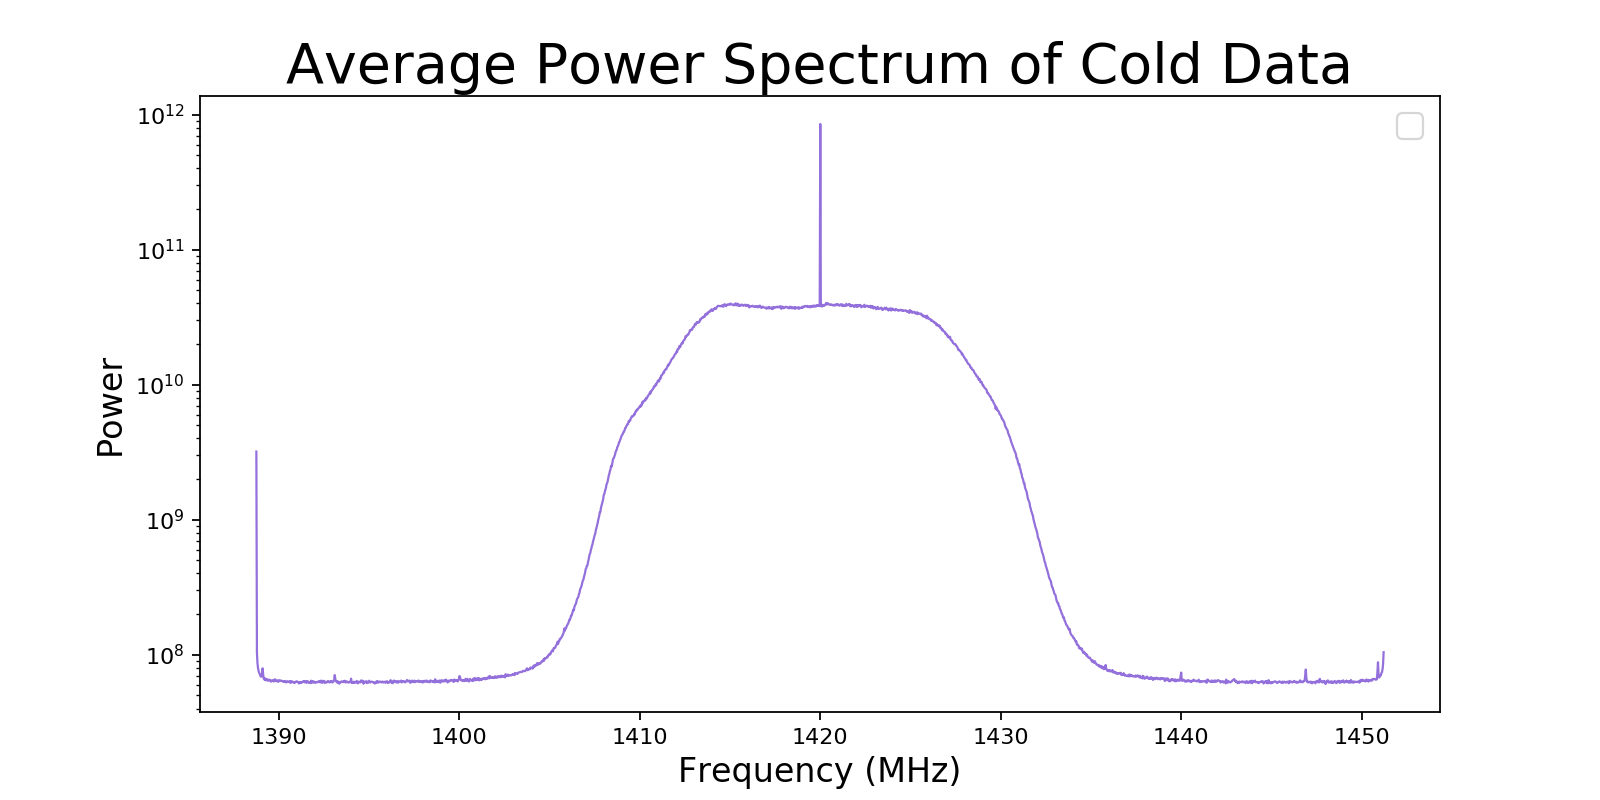

No handles with labels found to put in legend.


In [64]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.plot(freq + 1230 + 190, avg_power_array, "mediumpurple", linewidth=1)
plt.yscale("log")
plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Power", fontsize=15)
plt.title("Average Power Spectrum of Cold Data", fontsize=25)
plt.legend(fontsize=15)

#plt.xlim(-2, 2)
#plt.vlines(1420.4058, ymin=10e8, ymax=10e11, linewidth=.5)

In [65]:
# CAL DATA
cal_freq = np.fft.fftfreq(cal_data.shape[1], 1/62.5e6)
cal_freq = np.fft.fftshift(cal_freq)/1e6

blocks = 800
avg_rain_power_array = []
for n in range (0, blocks):
    data_new = cal_data[n]
    ft = np.fft.fft(data_new)
    ft = np.fft.fftshift(ft)
    power = abs(ft)**2
    avg_rain_power_array.append(power)
    
avg_rain_power_array = np.mean(avg_rain_power_array, axis=0)
s_cal = avg_rain_power_array

<IPython.core.display.Javascript object>


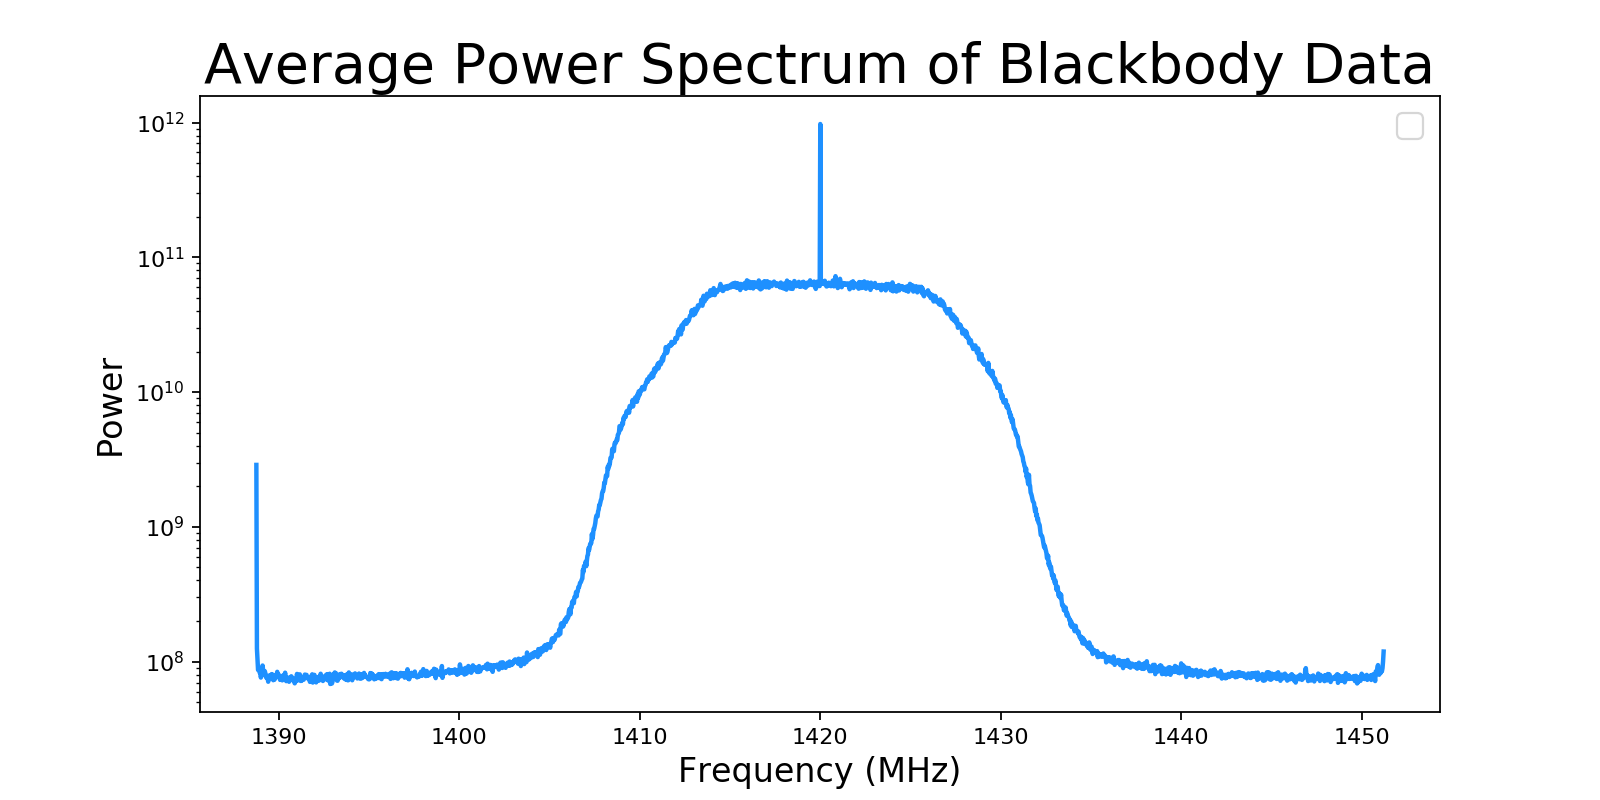

No handles with labels found to put in legend.


In [66]:
#%matplotlib notebook
plt.figure(figsize=(10,5))
plt.plot(cal_freq + 1230 + 190, avg_rain_power_array, "dodgerblue", linewidth=2)
plt.yscale("log")
plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Power", fontsize=15)
plt.title("Average Power Spectrum of Blackbody Data", fontsize=25)
plt.legend(fontsize=15)
#plt.xlim(-1, 1)
#plt.vlines(1420.4058, ymin=10e8, ymax=10e11, linewidth=.5)

<IPython.core.display.Javascript object>


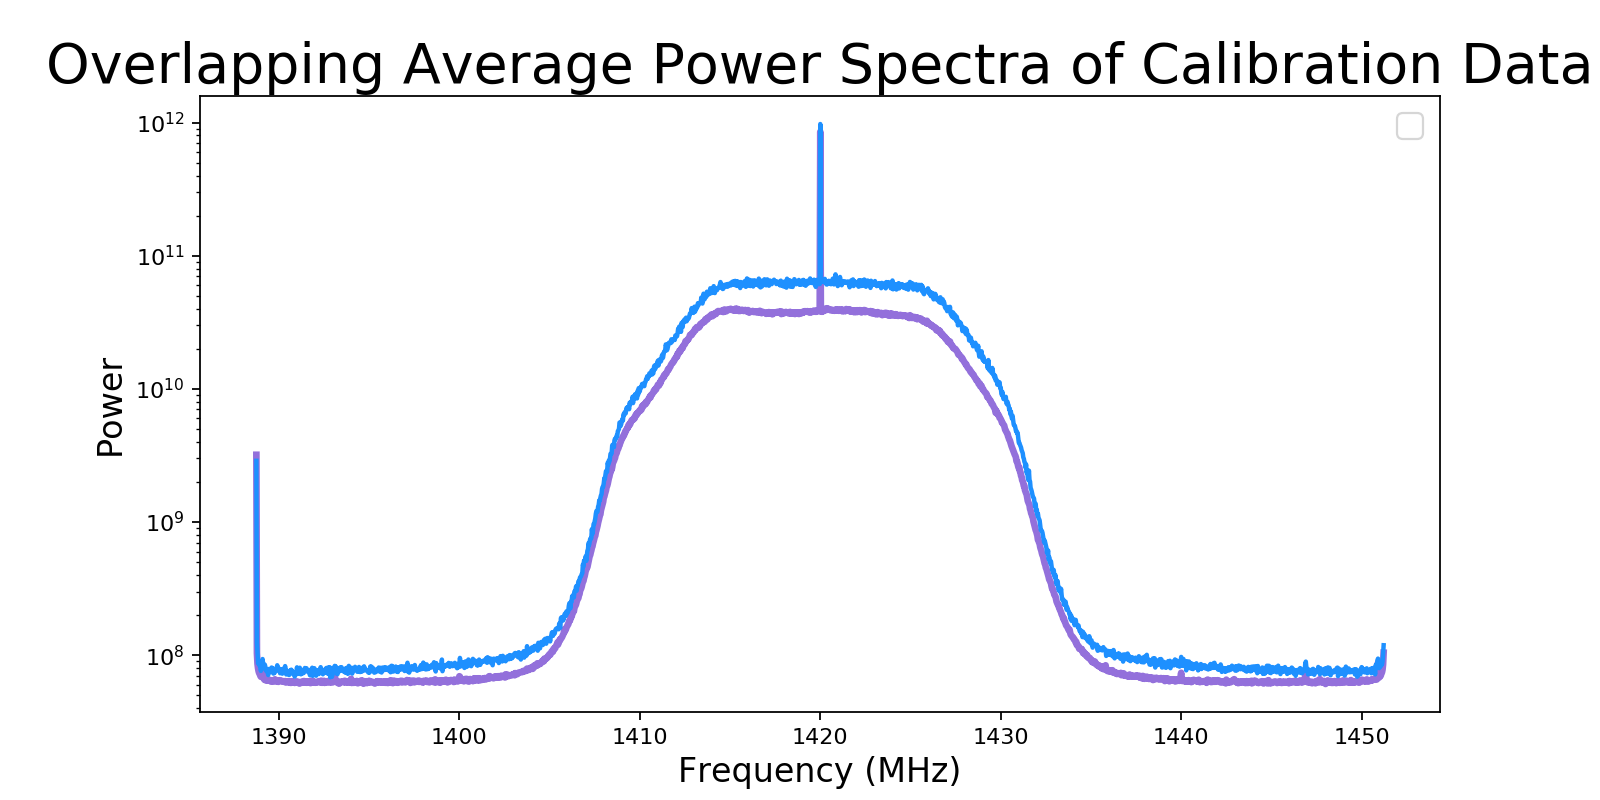

No handles with labels found to put in legend.


In [67]:
#%matplotlib notebook

plt.figure(figsize=(10,5))
plt.plot(freq + 1230 + 190, avg_power_array, "mediumpurple", linewidth=3)
plt.plot(cal_freq + 1230 + 190, avg_rain_power_array, "dodgerblue", linewidth=2)
plt.yscale("log")
plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Power", fontsize=15)
plt.title("Overlapping Average Power Spectra of Calibration Data", fontsize=25)
plt.legend(fontsize=15)
#plt.xlim(-1, 1)
#plt.vlines(1420.4058, ymin=10e8, ymax=10e11, linewidth=.5)

## Calculate Gain

In [68]:
# temperature
T_rx = 300 #kelvin
T_sky = 10 #between 10-100K
T_sys = T_rx - T_sky
T_sys

290

### filter positive frequencies

In [69]:
# shape
g_freq = freq + 1230 + 190
s_line = s_cold / s_cal
filtered_s_cold = np.array([s for s in s_cold if g_freq[list(s_cold).index(s)]<1420 and g_freq[list(s_cold).index(s)]>1390])
filtered_s_cal = np.array([s for s in s_cal if g_freq[list(s_cal).index(s)]<1420 and g_freq[list(s_cal).index(s)]>1390])
print(len(filtered_s_cold), len(filtered_s_cal))

959 959


In [70]:
G = T_sys/(np.sum(filtered_s_cal-filtered_s_cold)) * np.sum(filtered_s_cold)
T_line = s_line * G

In [71]:
print("Gain G = " + str(G))

Gain G = 498.02878253790897


# Estimate Optimal Time Range for Galactic Plane Observation

In [72]:
from astropy.coordinates import EarthLocation, SkyCoord

In [73]:
# determine galactic hydrogen source 

In [74]:
ugradio.timing.local_time()

'Wed Feb 17 23:24:07 2021'

In [75]:
# assumes we are at campbell
ugradio.timing.lst()

2.395601588178972

In [77]:
# ideal HI viewing time is at LST = 19 - 6
galactic_data = np.load('../Data/50mV hydrogen data.npz')

In [79]:
galactic_data.files

['arr_0']

In [80]:
galactic_data = galactic_data['arr_0'][0] - (galactic_data["arr_0"][1]*5/4*1j)

# resize blocks
galactic_data.shape = (-1, 2000)

In [82]:
# GALACTIC DATA
galactic_freq = np.fft.fftfreq(galactic_data.shape[1], 1/62.5e6)
galactic_freq = np.fft.fftshift(galactic_freq)/1e6

blocks = 8000
avg_galactic_power_array = []
for n in range (0, blocks):
    data_new = galactic_data[n]
    ft = np.fft.fft(data_new)
    ft = np.fft.fftshift(ft)
    power = abs(ft)**2
    avg_galactic_power_array.append(power)
    
avg_galactic_power_array = np.mean(avg_galactic_power_array, axis = 0)

<IPython.core.display.Javascript object>


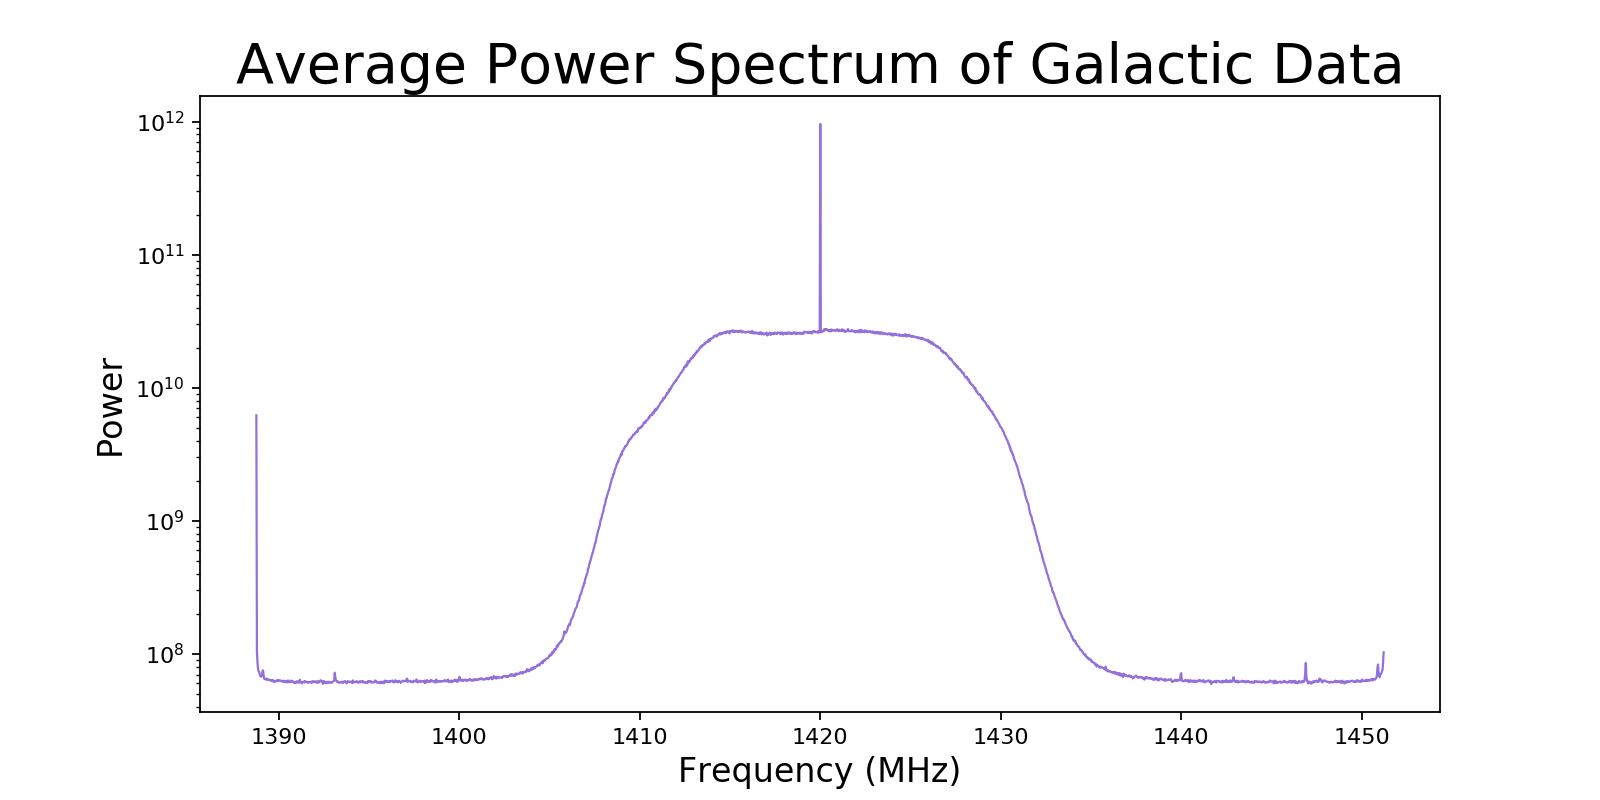

Text(0.5, 1.0, 'Average Power Spectrum of Galactic Data')

In [85]:
#%matplotlib notebook
plt.figure(figsize=(10,5))
plt.plot(freq + 1230 + 190, avg_galactic_power_array, "mediumpurple", linewidth=1)
plt.yscale("log")
plt.xlabel("Frequency (MHz)", fontsize=15)
plt.ylabel("Power", fontsize=15)
plt.title("Average Power Spectrum of Galactic Data", fontsize=25)

#plt.xlim(-2, 2)
#plt.vlines(1420.4058, ymin=10e8, ymax=10e11, linewidth=.5)